   *«Труднее всего дать хорошую рекомендацию человеку, которого очень хорошо знаешь.»*

   -- Френк Хаббард

# Рекомендация тарифов

В ходе данного анализа будет построена модель, прогнозирующая удобный новый тариф для перехода на него с архивного тарифного плана для соответсвующих клиентов оператора мобильной связи "Мегалайн". Для этого с помощью алгоритмов случайного леса и решающего дерева будут построены и сравнены модели для задачи классификации выбора подходящего тарифа.

## Данные

In [11]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification

Извлечём данные и посмотрим на них.

In [5]:
data = pd.read_csv('/datasets/users_behavior.csv')

data.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


Каждая строчка данных соответсвует поведению одного из пользователей за месяц. В данных присутствует информация о количестве звонков, суммарной длительности этих звонков в минутах, количестве смс-сообщений, израсходованный интернет-трафик и информация о выбранном тарифе.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


В приведённых данных отсутсвуют проспуски. Кроме того можно заменить тип данных в столбцах с количеством звонков и количеством минут на более подходящий для хранения информации о количестве.

In [7]:
data = data.astype({'calls': 'int'})
data = data.astype({'messages': 'int'})

Явных повторов в присутсвующих данных земечено не было. Искать неявные повторы в указанных данных искать не имеет смысла из-за характера представленных данных, поэтому будем считать, что в приведённых данных нет повторов.

In [8]:
data.duplicated().sum()

0

По данным можно видеть, что сильная кореляция наблюдается между количеством звонков и суммарной длительности всех звонков за указанный период.

In [13]:
data.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Кроме того, можно построить гистограммы распределений признаков.

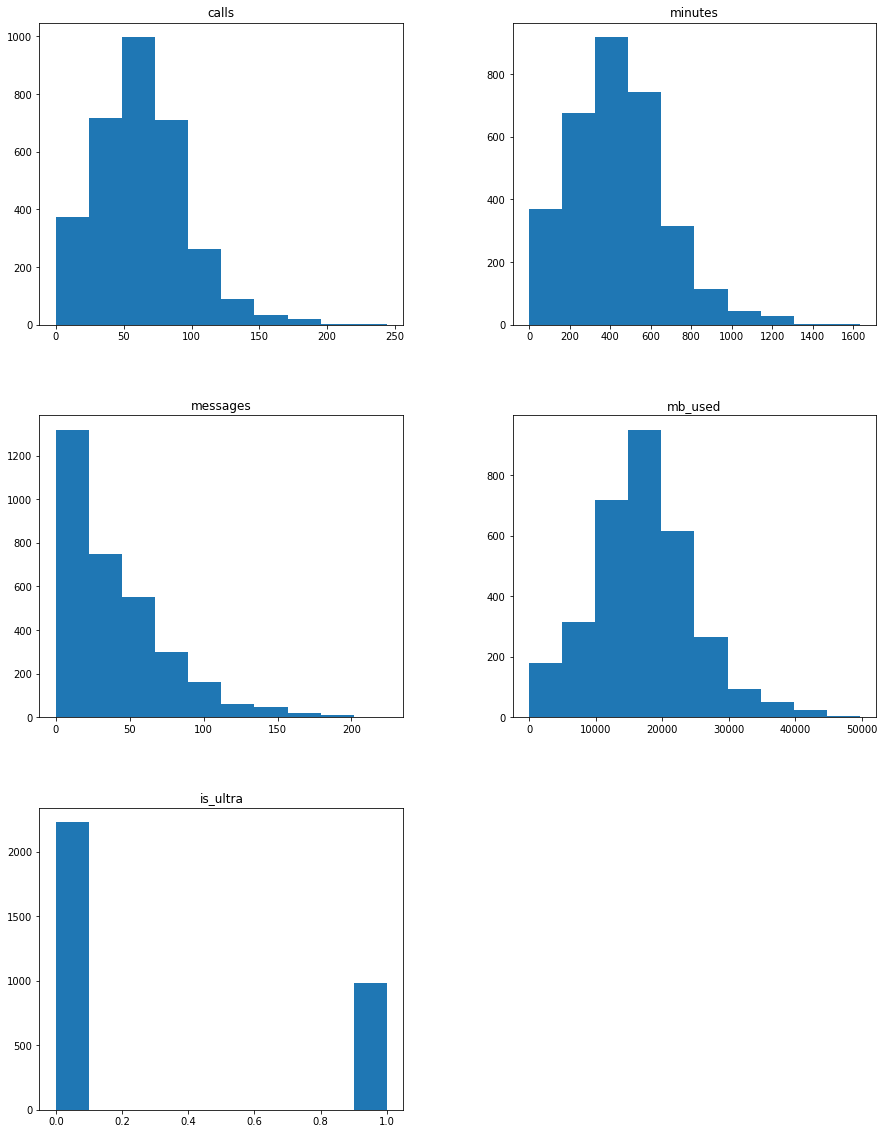

In [9]:
data.hist(figsize=(15, 20), grid=False)

## Выборки

Целевым признаком в нашем исследовании является тариф, на который перешёл пользователь. Отделим целевые признаки от нецелевых.

In [6]:
f = data.drop(['is_ultra'], axis=1)
t = data['is_ultra']

Разделим исходные данные на обучающую, валидационную и тестовую выборки в соотношение 3:1:1 (60%:20%:20%).

In [7]:
rrrr = 42 # random_state

# разбиение признаков
f_trn, f_vld, f_tst = \
              np.split(f.sample(frac=1, random_state=rrrr), 
                       [int(.6*len(f)), int(.8*len(f))])

# разбиение целевого признака
t_trn, t_vld, t_tst = \
              np.split(t.sample(frac=1, random_state=rrrr), 
                       [int(.6*len(t)), int(.8*len(t))])

## Модели

Поскольку целевые признаки имеют категориальную природу, то мы будем решать задачу классификации, а не регрессии. Т.е. мы постараемся определить по нецелевым признакам к какому тарифу они могут относится.

Первой моделью, которую мы задействуем будет модель решающего дерева. Её отличительными особенностями является низкая точность результатов, но более высокая скорость работы по сравнению с другими моделями. Последний фактор даёт нам возможность больше эксперементировать с различными параметрами модели и при этом быть уверенными, что задача будет решена за разумное время. В данном анализе мы задействуем такие параметры данной модели как:
- минимальное количество примеров для разделения
- минимальное количество объектов в листе
- глубина дерева

Также, мы рассмотрим влияние выбора функции для оценки качества распределения, а именно критерия Джини и критерия Шеннона.

In [8]:
b_dtc_m_gini = None  # лучшая модель
b_dtc_acc_gini = 0   # точность лучшей модели
for a in np.arange(0.1,1,0.1):
    for b in np.arange(0.1,0.5,0.1):
        for i in range(1,11):
            # обучаем модель с заданными
            # - глубиной деревьев
            # - минимальными количеством примеров для разделения
            # - минимальным количеством объектов в листе
            m = DecisionTreeClassifier(random_state=rrrr, criterion='gini',
                                       min_samples_split=a, min_samples_leaf=b,
                                       max_depth=i)
            m.fit(f_trn,t_trn) # тренируем модель по тренировочной выборке
            acc = m.score(f_vld,t_vld) # точность по валидационной выборке
            if acc > b_dtc_acc_gini:
                b_dtc_m_gini = m
                b_dtc_acc_gini = acc
b_dtc_acc_gini

0.7573872472783826

In [9]:
b_dtc_m_etp = None  # лучшая модель
b_dtc_acc_etp = 0   # точность лучшей модели
for a in np.arange(0.1,1,0.1):
    for b in np.arange(0.1,0.5,0.1):
        for i in range(1,11):
            # обучаем модель с заданными
            # - глубиной деревьев
            # - минимальными количеством примеров для разделения
            # - минимальным количеством объектов в листе
            m = DecisionTreeClassifier(random_state=rrrr, criterion='entropy',
                                       min_samples_split=a, min_samples_leaf=b,
                                       max_depth=i)
            m.fit(f_trn,t_trn) # тренируем модель по тренировочной выборке
            acc = m.score(f_vld,t_vld) # точность по валидационной выборке
            if acc > b_dtc_acc_etp:
                b_dtc_m_etp = m
                b_dtc_acc_etp = acc
b_dtc_acc_etp

0.7573872472783826

Можно убедиться в том, что в данном анализе выбор функции для оценки распределения не влияет на максимальную точность модели. Максимальная точность, которую можно получить из данного алгоритма при переборе данных параметров ~76%.

---

Кроме можно рассмотреть ещё одну модель, модель случайного леса. Её отличительными особенностями являются высокая получаемая точность, но более низкая скорость обучения. Поэтому, чтобы избежать лишней траты времени, ограничимся рассмотрением изменения только одного параметра -- количества деревьев.

In [10]:
b_rfc_m = None  # лучшая модель
b_rfc_acc = 0   # точность лучшей модели
for i in range(1, 11):
    m = RandomForestClassifier(random_state=rrrr, n_estimators=i) # обучаем модель с заданным количеством деревьев
    m.fit(f_trn,t_trn) # тренируем модель по тренировочной выборке
    acc = m.score(f_vld,t_vld) # точность по валидационной выборке
    if acc > b_rfc_acc:
        b_rfc_m = m
        b_rfc_acc = acc
b_rfc_acc

0.8009331259720062

Модель случайного леса является более точной по сравнению с моделью решаюшего дерева даже с учётом возможности перебора большего количества параметров в последней.

## Тест

Проверим модели с наилучшими параметрами на тестовой выбоке и сравним их точности, получененные на валидационной выборке и тестовой.

In [11]:
m = b_dtc_m_gini       # берём наиболее удачную модель
m.fit(f_trn,t_trn)     # тренируем модель по тренировочной выборке

p_vld = m.predict(f_vld) # предсказания по валидационной выборке
p_tst = m.predict(f_tst) # предсказания по тестовой выборке

print("Валидационная выборка:", accuracy_score(t_vld,p_vld))
print("Тестовая выборка:", accuracy_score(t_tst,p_tst))

Валидационная выборка: 0.7573872472783826
Тестовая выборка: 0.7729393468118196


In [12]:
m = b_dtc_m_etp        # берём наиболее удачную модель
m.fit(f_trn,t_trn)     # тренируем модель по тренировочной выборке

p_vld = m.predict(f_vld) # предсказания по валидационной выборке
p_tst = m.predict(f_tst) # предсказания по тестовой выборке

print("Валидационная выборка:", accuracy_score(t_vld,p_vld))
print("Тестовая выборка:", accuracy_score(t_tst,p_tst))

Валидационная выборка: 0.7573872472783826
Тестовая выборка: 0.7729393468118196


Как можно заметить, для модели решающего дерева точность тестовой выборки несколько выше точности валидационной.

In [13]:
m = b_rfc_m        # берём наиболее удачную модель
m.fit(f_trn,t_trn) # тренируем модель по тренировочной выборке

p_vld = m.predict(f_vld) # предсказания по валидационной выборке
p_tst = m.predict(f_tst) # предсказания по тестовой выборке

print("Валидационная выборка:", accuracy_score(t_vld,p_vld))
print("Тестовая выборка:", accuracy_score(t_tst,p_tst))

Валидационная выборка: 0.8009331259720062
Тестовая выборка: 0.7838258164852255


При этом точность для тестовой выборке в моделе случайного леса несколько ниже чем для валидационной, но попрежнему выше, чем любая полученная для модели решающего дерева.

## Вывод

В ходе данного исследования была получена модель, способная предсказать наиболее удобный для клиента тариф по его активности за месяц. Точность такой модели составила ~78%, однако следует отметить, что данная цифра справедлива, если мы исходим из предположения, что каждый пользователь выбрал для себя удобный тариф, что, строго говоря, может оказаться неверным, также следует иметь ввиду отсутствие некоторых потенциально важных параметров в данной модели, например разница цены тарифа при переходе с архивного тарифа на один из текущих, что также может влиять на качество предсказаний для новых клиентов. Негативно на точность предсказаний может влиять и то, что для её построения используются данные за определённый непродолжительный период, соответсвенно чтобы сохранять актуальность предсказаний и отслеживать их динамику следует регулярно перестраивать данную модель.